### QML 3a.  Variational Quantum Classifier (VQCs) or Quantum Neural Networks (QNNs)
The goal is to find a function $f$ with parameters $\theta$ that maps a data vector / image $\vec{x}$ to the correct category: $f_\theta(\vec{x}) \rightarrow \pm1$. This will be accomplished using a VQC with few layers that can be identified by their distinct purposes:

$$
f_\theta(\vec{x}) = \langle 0|U^{\dagger}(\vec{x})W^\dagger(\theta)OW(\theta)U(\vec{x})|0\rangle
$$

Here, $U(\vec{x})$ is the encoding circuit, for which we have many options as seen in previous lessons. $W(\theta)$ is a variational, or trainable circuit block, and $\theta$ is the set of parameters to be trained. Those parameters will be varied by classical optimization algorithms to find the set of parameters that yields the best classification of images by the quantum circuit. This variational circuit is sometimes called the "ansatz". Finally, $O$ is some observable that will be estimated using the Estimator primitive. There is no constraint that forces the layers to come in this order, or even to be fully separate. One could have multiple variational and/or encoding layers in any order that is technically motivated.

If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

### 1. Dataset
Let us create a toy data set with one feature and labels 1 or -1 randomaly and vizualize it

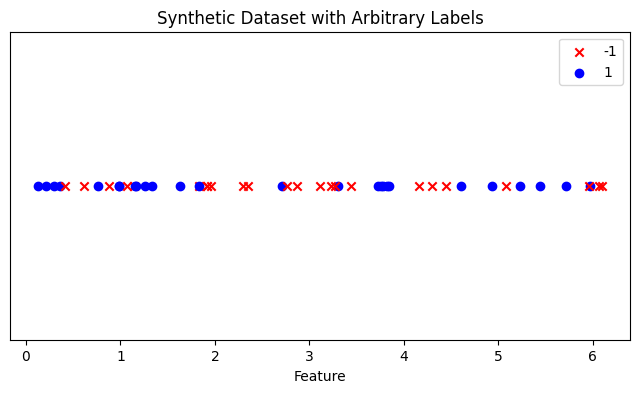

In [1]:
# Assign arbitrary labels (-1 or 1) randomly to each sample
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
X = np.random.rand(50) * 2*np.pi  # 20 random samples in range [0, 10]
y_arbitrary = np.random.choice([-1, 1], size=X.shape)

# Plot with arbitrary labels
plt.figure(figsize=(8, 4))
for xi, yi in zip(X, y_arbitrary):
    if yi == 1:
        plt.scatter(xi, 0, marker='o', color='blue', label='1' if '1' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(xi, 0, marker='x', color='red', label='-1' if '-1' not in plt.gca().get_legend_handles_labels()[1] else "")
plt.xlabel('Feature')
plt.yticks([])
plt.legend()
plt.title('Synthetic Dataset with Arbitrary Labels')
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_arbitrary, test_size=0.3, random_state=42)

In [3]:
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
print('test size:', test_size, ', train size:', train_size)

test size: 15 , train size: 35


### 2. U(x,$\theta$)
Let us create a simple variational circuit for data input and with a weight parameter

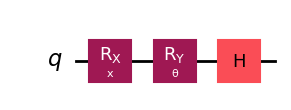

In [4]:
from qiskit.circuit import Parameter, QuantumCircuit

circuit = QuantumCircuit(1)
x = Parameter('x')
theta = Parameter('θ')
circuit.rx(x, 0)
circuit.ry(theta, 0)
circuit.h(0)


circuit.draw('mpl')

In [5]:
circuit.parameters

ParameterView([Parameter(x), Parameter(θ)])

In [6]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("Z", 1)])
observable

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])

### 3. Define a function for forward pass
The function takes as input circuit, weight paramters and input data, estimator and observables and gives an array of expectation values as output

In [7]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
import numpy as np

def forward(circuit,input_params,weight_params,estimator,observable):
    num_samples = input_params.shape[0]
    weights0 = np.full_like(input_params, weight_params[0])
    params= [[inp, w0] for inp, w0 in zip(input_params, weights0)]
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
    return expectation_values

let us choose a simple loss

In [8]:
def mse_loss(predict, target):
    return ((predict - target) ** 2).mean()


### 4. Define function to compute cost for given weight parameters

In [9]:
def mse_loss_weights(weight_params):
    predictions = forward(circuit=circuit,input_params=input_params,
        weight_params=weight_params,estimator=estimator,observable=observable)

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 10 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

### 5. Training
Use a chosen optimization routine

In [10]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
import numpy as np
num_epochs = 1
num_samples = len(X_train)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

weight_params = np.random.rand() * 2 * np.pi

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    input_params = X_train
    target = y_train
    iter = 0
    res = minimize(
        mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 100,'tol': 1e-8}
    )
    weight_params = res["x"]

Epoch: 0
Iter: 0, loss: 1.9507547147112583
Iter: 10, loss: 0.9076923845976616
Iter: 20, loss: 0.9076829267526593
Iter: 30, loss: 0.9076828874058518


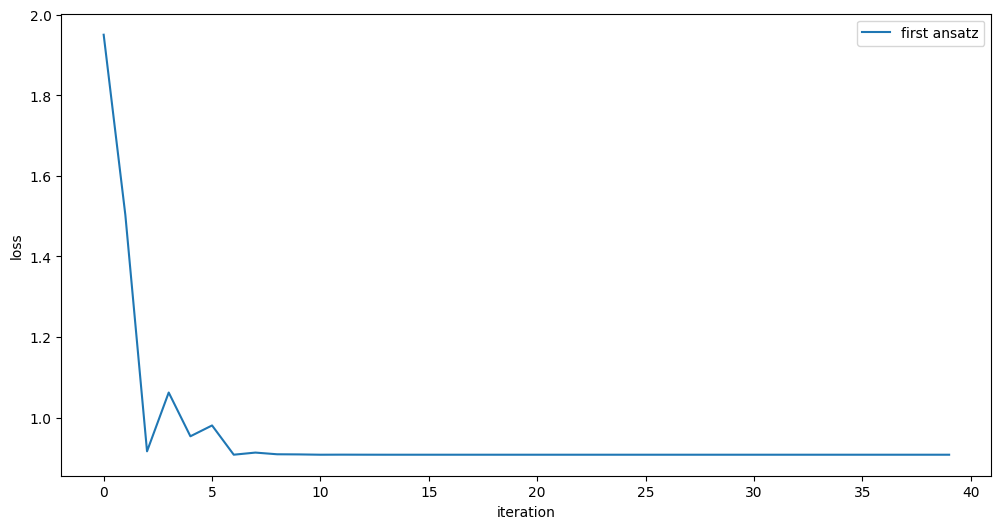

In [11]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

### 6. Training accuracy

In [12]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(y_train)

accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.39215717 -0.41961211 -0.15872785 -0.41647204  0.17057849 -0.10931771
 -0.14032164 -0.40391424  0.41005504  0.20102995 -0.29598788 -0.02314732
 -0.41812695  0.39833997  0.23379109  0.40205187  0.41232434 -0.14124487
  0.39983635  0.268621   -0.04739354  0.35348922  0.15060223 -0.28030625
  0.30231926  0.41629853 -0.10987082 -0.38200679  0.16707687 -0.320328
  0.27994143  0.41004342  0.17437696 -0.35099966 -0.16857934]
[ 1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.]
[ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1 -1
  1  1  1  1  1  1  1  1 -1  1 -1]
Train accuracy: 62.857142857142854%


### 7. Test accuracy

In [13]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.0984141  -0.39047258 -0.32755449 -0.21929731 -0.41473638 -0.40185411
  0.13054492  0.09203049  0.38522378 -0.10753834  0.20786452  0.23373825
  0.34320198 -0.33789222 -0.34169707]
[ 1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.]
[ 1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1  1  1]
Test accuracy: 60.0%
